In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression

In [42]:
df = pd.read_csv('df_hack_final.csv')

In [43]:
df.describe()

Cu_oreth      Ni_oreth      Ore_mass        Mass_1        Mass_2  \
count  26213.000000  26213.000000  30336.000000  30336.000000  30336.000000   
mean       2.712405      1.685584   1213.996028   1346.755948    789.375929   
std        0.284495      0.163395    304.202121    272.748762    153.755873   
min        1.654600      1.141700      0.000000     -0.258293     -0.167950   
25%        2.523700      1.574000   1133.500000   1310.454010    762.188248   
50%        2.694400      1.685100   1274.500000   1400.961060    817.151642   
75%        2.894800      1.792700   1395.500000   1475.273743    864.989029   
max        4.048000      2.617300   2000.000000   2089.517578   1221.758057   

             Dens_4        Mass_4         Vol_4         Cu_4F         Ni_4F  \
count  30336.000000  30336.000000  30336.000000  26083.000000  26083.000000   
mean       1.386676    811.542840   1520.387530      0.477034      2.841660   
std        0.072671    147.976016    254.858332      0.176787      0.196178   
min        0.000000     -0.083749      0.000000      0.100100      0.680600   
25%        1.378594    791.388550   1523.531250      0.396900      2.713750   
50%        1.398115    836.229218   1562.812500      0.468100      2.840300   
75%        1.415396    875.025543   1595.750000      0.541200      2.967500   
max        1.651951   1303.474609   2028.375000      5.205700      3.668900   

       ...   Cu_3.1T_max   Cu_3.1T_min      FM_3.2_A   Cu_3.2C_max  \
count  ...  30335.000000  30335.000000  30335.000000  30335.000000   
mean   ...      1.627824      0.818042      0.331235     15.653601   
std    ...      0.328567      0.170884      0.470665      0.901482   
min    ...      1.000000      0.600000      0.000000     14.000000   
25%    ...      1.400000      0.600000      0.000000     15.000000   
50%    ...      1.800000      0.800000      0.000000     15.500000   
75%    ...      1.800000      0.900000      1.000000     16.500000   
max    ...      2.000000      1.200000      1.000000     17.000000   

        Cu_3.2C_min   Ni_3.2C_max  Ni_3.2C_min   Cu_3.2T_max   Cu_3.2T_min  \
count  30335.000000  3.033500e+04      30335.0  30335.000000  30335.000000   
mean      13.036163  3.700000e+00          3.5      1.576072      0.863170   
std        0.573167  1.910947e-12          0.0      0.236993      0.166731   
min       12.000000  3.700000e+00          3.5      1.000000      0.600000   
25%       13.000000  3.700000e+00          3.5      1.400000      0.700000   
50%       13.000000  3.700000e+00          3.5      1.600000      0.900000   
75%       13.000000  3.700000e+00          3.5      1.800000      1.000000   
max       15.000000  3.700000e+00          3.5      1.800000      1.300000   

             Ni_rec  
count  27759.000000  
mean       0.947898  
std        0.020704  
min        0.594336  
25%        0.933853  
50%        0.943993  
75%        0.966216  
max        1.000000  

[8 rows x 129 columns]

приводим даты к типам данных datetime

In [45]:
df['MEAS_DT'] = pd.to_datetime(df['MEAS_DT'])

In [46]:
df['FM1_sum'] = df['Ni_1.1C'] + df['Ni_1.2C']
df['FM2_sum'] = df['Ni_2.1C'] + df['Ni_2.2C']
df['FM3_sum'] = df['Ni_3.1C'] + df['Ni_3.2C']
df['FM4_sum'] = df['Ni_4.1C'] + df['Ni_4.2C']
df['FM5_sum'] = df['Ni_5.1C'] + df['Ni_5.2C']
df['FM6_sum'] = df['Ni_6.1C'] + df['Ni_6.2C']

подбираем параметр offset для того, чтобы графически определить сонаправленное движение метрик при смещении шкалы времени. Видим совпадения при смещении в 105 минут (семь 15-минуток) на первой флотомашине. Следует заметить, что этот промежуток времени учитывает также время транспортировки смеси (материала? пульпы?), поскольку смотрим на метрики "от выхода до выхода"

In [47]:
df['MEAS_DT_new'] = df['MEAS_DT'] + pd.DateOffset(minutes=105)

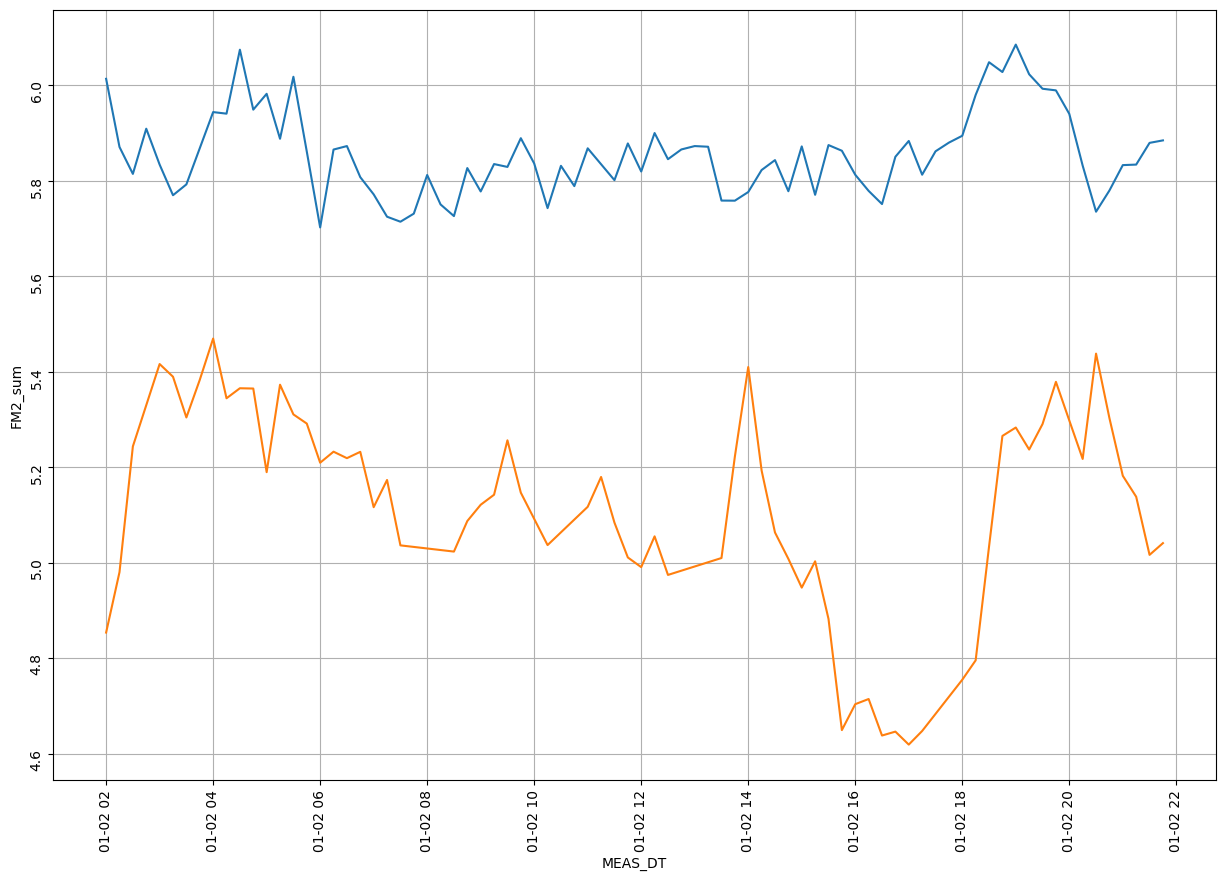

In [239]:
fig = plt.figure(figsize=(15, 10))
sns.lineplot(df[(df['Ni_rec'] < 1.00) & (df['MEAS_DT'].astype(str) < '2024-01-02 22') & (df['MEAS_DT'].astype(str) > '2024-01-02 02')], x='MEAS_DT', y='FM2_sum').tick_params(labelrotation = 90)
sns.lineplot(df[(df['Ni_rec'] < 1.00) & (df['MEAS_DT_new'].astype(str) < '2024-01-02 22') & (df['MEAS_DT_new'].astype(str) > '2024-01-02 02')], x='MEAS_DT_new', y='FM1_sum')
plt.grid(visible=True)
fig.show()

копируем часть датасета для дальнейшей работой с копией. Также, аналогично (графически) определили, что время флотации+транспортировки на 6й флотомашине равняется примерно 30 минутам. Далее исходим из предположения, что время флотации линейно снижается от одной флотомашины к другой, при этом оставаясь константным с течением времени для каждой отдельно взятой флотомашины

In [50]:
df_working = df[['Cu_1.1C',
 'Cu_1.1C_max',
 'Cu_1.1C_min',
 'Cu_1.2C',
 'Cu_1.2C_max',
 'Cu_1.2C_min',
 'Cu_2.1C',
 'Cu_2.1C_max',
 'Cu_2.1C_min',
 'Cu_2.1T',
 'Cu_2.1T_max',
 'Cu_2.1T_min',
 'Cu_2.2C',
 'Cu_2.2C_max',
 'Cu_2.2C_min',
 'Cu_2.2T',
 'Cu_2.2T_max',
 'Cu_2.2T_min',
 'Cu_2F',
 'Cu_3.1C',
 'Cu_3.1C_max',
 'Cu_3.1C_min',
 'Cu_3.1T',
 'Cu_3.1T_max',
 'Cu_3.1T_min',
 'Cu_3.2C',
 'Cu_3.2C_max',
 'Cu_3.2C_min',
 'Cu_3.2T',
 'Cu_3.2T_max',
 'Cu_3.2T_min',
 'Cu_3F',
 'Cu_4F',
 'FM_1.1_A',
 'FM_1.2_A',
 'FM_2.1_A',
 'FM_2.2_A',
 'FM_3.1_A',
 'FM_3.2_A',
 'FM_4.1_A',
 'FM_4.2_A',
 'FM_5.1_A',
 'FM_5.2_A',
 'FM_6.1_A',
 'FM_6.2_A',
 'MEAS_DT',
 'Ni_1.1C',
 'Ni_1.1C_max',
 'Ni_1.1C_min',
 'Ni_1.1T_max',
 'Ni_1.1T_min',
 'Ni_1.2C',
 'Ni_1.2C_max',
 'Ni_1.2C_min',
 'Ni_1.2T_max',
 'Ni_1.2T_min',
 'Ni_2.1C',
 'Ni_2.1T',
 'Ni_2.2C',
 'Ni_2.2T',
 'Ni_2F',
 'Ni_3.1C',
 'Ni_3.1C_max',
 'Ni_3.1C_min',
 'Ni_3.1T',
 'Ni_3.2C',
 'Ni_3.2C_max',
 'Ni_3.2C_min',
 'Ni_3.2T',
 'Ni_3F',
 'Ni_4.1C',
 'Ni_4.1C_max',
 'Ni_4.1C_min',
 'Ni_4.1T',
 'Ni_4.1T_max',
 'Ni_4.1T_min',
 'Ni_4.2C',
 'Ni_4.2C_max',
 'Ni_4.2C_min',
 'Ni_4.2T',
 'Ni_4.2T_max',
 'Ni_4.2T_min',
 'Ni_4F',
 'Ni_5.1C',
 'Ni_5.1C_max',
 'Ni_5.1C_min',
 'Ni_5.1T',
 'Ni_5.1T_max',
 'Ni_5.1T_min',
 'Ni_5.2C',
 'Ni_5.2C_max',
 'Ni_5.2C_min',
 'Ni_5.2T',
 'Ni_5.2T_max',
 'Ni_5.2T_min',
 'Ni_5F',
 'Ni_6.1C',
 'Ni_6.1C_max',
 'Ni_6.1C_min',
 'Ni_6.1T',
 'Ni_6.1T_max',
 'Ni_6.1T_min',
 'Ni_6.2C',
 'Ni_6.2C_max',
 'Ni_6.2C_min',
 'Ni_6.2T',
 'Ni_6.2T_max',
 'Ni_6.2T_min',
 'Ni_6F',
 'Ni_oreth',
 'Ni_rec',
 'Ni_resth',
 'Ore_mass',
 'Mass_1',
 'Mass_2',
 'Mass_3',
 'Mass_4',
 'Mass_5',
 'Mass_6',
 'Dens_1',
 'Dens_2',
 'Dens_3',
 'Dens_4',
 'Dens_5',
 'Dens_6']]

df_working['time_1'] = df_working['MEAS_DT'] + pd.DateOffset(minutes=105)
df_working['time_2'] = df_working['MEAS_DT'] + pd.DateOffset(minutes=90)
df_working['time_3'] = df_working['MEAS_DT'] + pd.DateOffset(minutes=75)
df_working['time_4'] = df_working['MEAS_DT'] + pd.DateOffset(minutes=60)
df_working['time_5'] = df_working['MEAS_DT'] + pd.DateOffset(minutes=45)
df_working['time_6'] = df_working['MEAS_DT'] + pd.DateOffset(minutes=30)

**1. хотим понимать как сделать выход каждой бочки из суммы по флотомашине (либо через замену на среднее)**

**2. Ni_rec максимизируем, а Ni_6.1C и Ni_6.2C заказывается**

**3. сделаем регрессии и пределы на каждую бочку (или флотомашину)**

**4. опираться будем на логику физ. процесса и движение смеси по схеме**

время прохождения всего цикла обогащения для одной порции пульпы определяем как 405 минут

In [51]:
df_working['time_full'] = df_working['MEAS_DT'] + pd.DateOffset(minutes=405)

Здесь и далее будем усреднять выводы флотаторов внутри каждой флотомашины. Это сделано в целях экономии времени. Более правильным было бы учитывать долю концентрата, которую вносит в сумму по флотомашине каждый из флотаторов

In [52]:
df_working['Ni_6_sum'] = (df_working['Ni_6.1C'] + df_working['Ni_6.2C']) / 2
df_working['Ni_6_tail_sum'] = (df_working['Ni_6.1T'] + df_working['Ni_6.2T']) / 2

Здесь и далее будем смещать значение среднего выхода по времени на количество 15-минуток определенное ранее. В случае ФМ 6 - это 30 минут (две 15-минутки)

In [53]:
df_working['Ni_6_sum_shifted'] = df_working['Ni_6_sum'].shift(2)
df_working['Ni_6_tail_sum_shifted'] = df_working['Ni_6_tail_sum'].shift(2)

будем пытаться максимизировать Ni_rec. в целях экономии времени зафиксируем его на уровне 0,97 (+- 0.005)

In [54]:
upper_bound_final = 0.975
lower_bound_final = 0.965

data_for_final_step = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04') & (df_working['Ni_rec'] >= lower_bound_final) & (df_working['Ni_rec'] <= upper_bound_final)]
data_for_final_step_full = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04') & (df_working['Ni_rec'] > 0.6)]

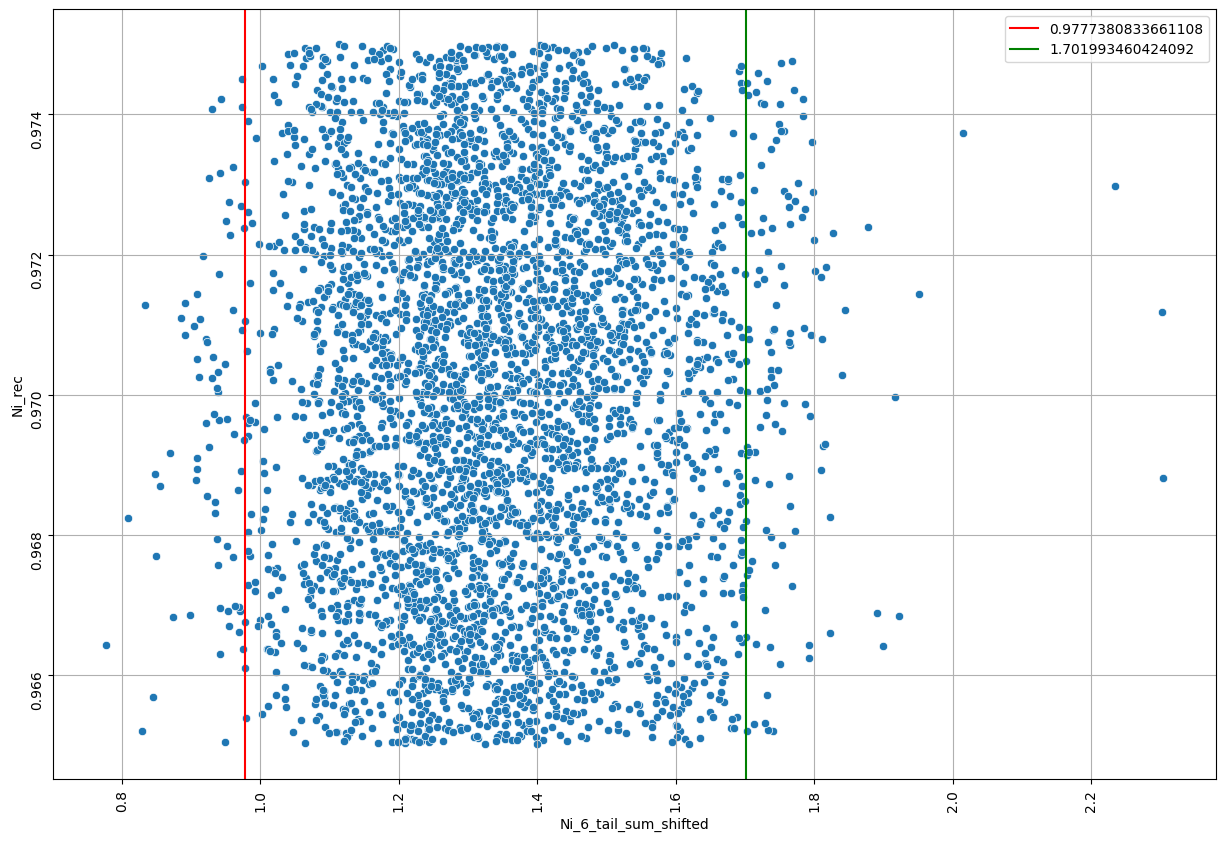

In [55]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_final_step, x='Ni_6_tail_sum_shifted', y='Ni_rec').tick_params(labelrotation = 90)
plt.axvline(x=data_for_final_step['Ni_6_tail_sum_shifted'].mean() - 1.96 * data_for_final_step['Ni_6_tail_sum_shifted'].std(),
            color='r',
            linestyle='-',
            label=data_for_final_step['Ni_6_tail_sum_shifted'].mean() - 1.96 * data_for_final_step['Ni_6_tail_sum_shifted'].std())
plt.axvline(x=data_for_final_step['Ni_6_tail_sum_shifted'].mean() + 1.96 * data_for_final_step['Ni_6_tail_sum_shifted'].std(),
            color='g',
            linestyle='-',
            label=data_for_final_step['Ni_6_tail_sum_shifted'].mean() + 1.96 * data_for_final_step['Ni_6_tail_sum_shifted'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

ОБОСНОВАНИЕ ДЛЯ ВЫБОРА 0.97

Визуально наблюдаем на графике зависимости Ni_rec от смещенного среднего выхода ФМ6 **два кластера**, с некоторой дисперсией сосредоточенных вокруг значений 0.94 и 0.97; будем выбирать максимальное из двух

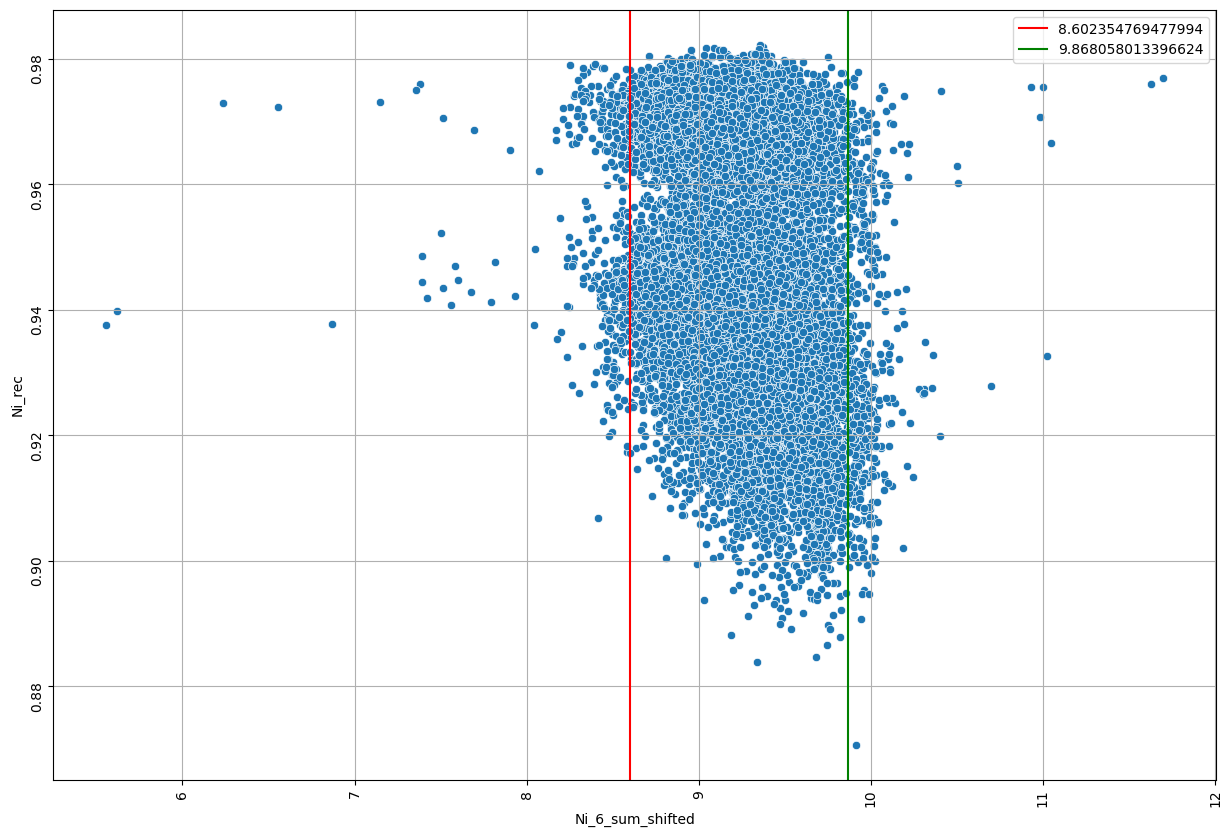

In [56]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_final_step_full, x='Ni_6_sum_shifted', y='Ni_rec').tick_params(labelrotation = 90)
plt.axvline(x=data_for_final_step_full['Ni_6_sum_shifted'].mean() - 1.96 * data_for_final_step_full['Ni_6_sum_shifted'].std(),
            color='r',
            linestyle='-',
            label=data_for_final_step_full['Ni_6_sum_shifted'].mean() - 1.96 * data_for_final_step_full['Ni_6_sum_shifted'].std())
plt.axvline(x=data_for_final_step_full['Ni_6_sum_shifted'].mean() + 1.96 * data_for_final_step_full['Ni_6_sum_shifted'].std(),
            color='g',
            linestyle='-',
            label=data_for_final_step_full['Ni_6_sum_shifted'].mean() + 1.96 * data_for_final_step_full['Ni_6_sum_shifted'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

Получаем следующее облако точек. Напоминает случайное распределение внутри диапазона с незначительными выбросами. Зависимость здесь не наблюдаем, поэтому регрессию строить не будем (см. следующий шаг). Ограничим диапазон только 95% доверительным интервалом

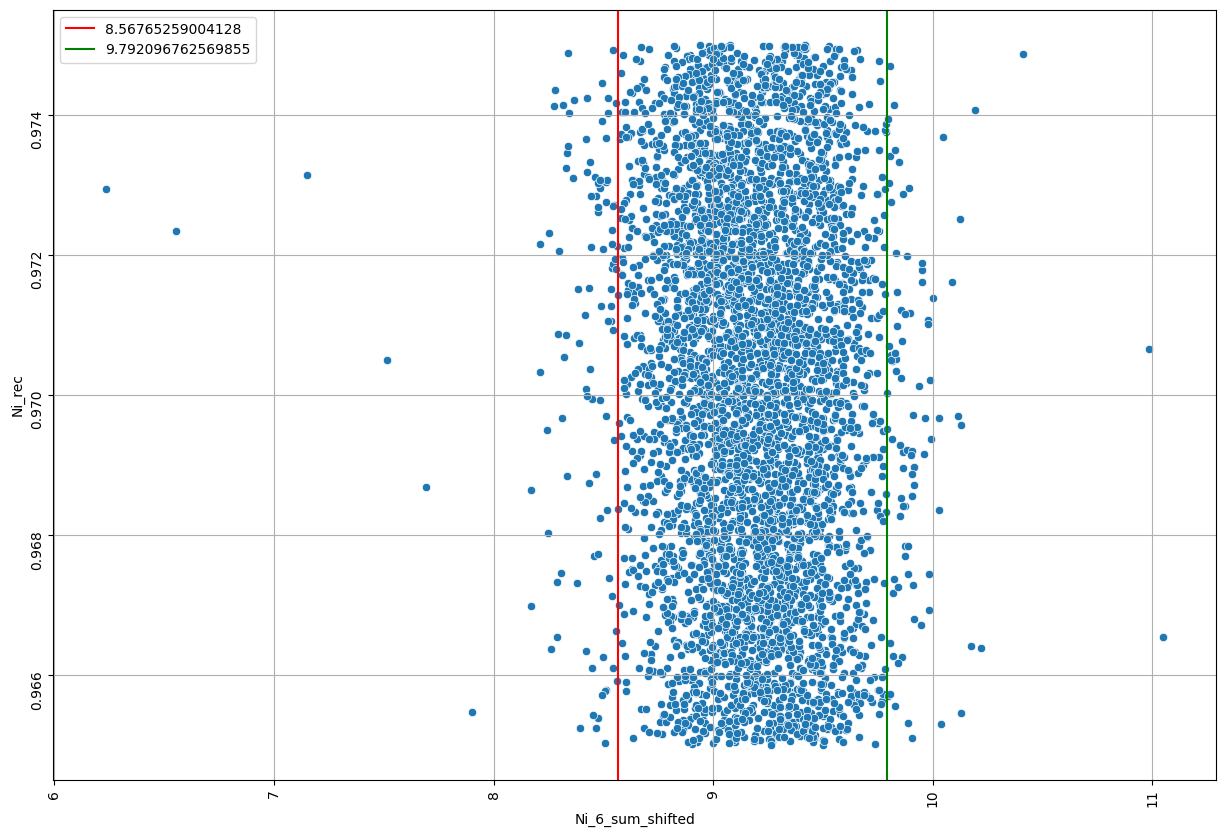

In [57]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_final_step, x='Ni_6_sum_shifted', y='Ni_rec').tick_params(labelrotation = 90)
plt.axvline(x=data_for_final_step['Ni_6_sum_shifted'].mean() - 1.96 * data_for_final_step['Ni_6_sum_shifted'].std(),
            color='r',
            linestyle='-',
            label=data_for_final_step['Ni_6_sum_shifted'].mean() - 1.96 * data_for_final_step['Ni_6_sum_shifted'].std())
plt.axvline(x=data_for_final_step['Ni_6_sum_shifted'].mean() + 1.96 * data_for_final_step['Ni_6_sum_shifted'].std(),
            color='g',
            linestyle='-',
            label=data_for_final_step['Ni_6_sum_shifted'].mean() + 1.96 * data_for_final_step['Ni_6_sum_shifted'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

по аналогии с предыдущим шагом усредняем и смещаем выводы ФМ5

In [60]:
df_working['Ni_5_sum'] = (df_working['Ni_5.1C'] + df_working['Ni_5.2C']) / 2
df_working['Ni_5_sum_shifted'] = df_working['Ni_5_sum'].shift(3)

ограничим результирующие выходы ФМ6, чтобы обучаться под более стабильные параметры ФМ6 (поскольку ее перфоманс зависит от полученного концентрата с ФМ5)

In [61]:
lower_bound_6 = data_for_final_step['Ni_6_sum_shifted'].mean() - 1.96 * data_for_final_step['Ni_6_sum_shifted'].std()
upper_bound_6 = data_for_final_step['Ni_6_sum_shifted'].mean() + 1.96 * data_for_final_step['Ni_6_sum_shifted'].std()

data_for_step_6 = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04') & (df_working['Ni_6_sum'] > lower_bound_6) & (df_working['Ni_6_sum'] < upper_bound_6)]

Обучим линейную регрессию для определения оптимального диапазона ФМ6 исходя из полученного значения ФМ5. От полученной регрессионной прямой отложим одинаковые дельты в обе стороны. Это будут наши диапазоны ФМ6 на основе полученного вывода ФМ5

In [62]:
model_5 = LinearRegression()

model_5.fit(X=data_for_step_6[['Ni_5_sum_shifted']].fillna(data_for_step_6[['Ni_5_sum_shifted']].mean()), y=data_for_step_6['Ni_6_sum'].fillna(data_for_step_6['Ni_6_sum'].mean()))

y_hat_5 = model_5.predict(data_for_step_6[['Ni_5_sum_shifted']].fillna(data_for_step_6[['Ni_5_sum_shifted']].mean()))
data_for_step_6['Ni5_predict'] = y_hat_5
data_for_step_6['Ni5_predict_upper'] = y_hat_5 + y_hat_5*0.07
data_for_step_6['Ni5_predict_lower'] = y_hat_5 - y_hat_5*0.07

### К сожалению, не успеваю описать комментариями оставшийся код до дедлайна. эти ключевые два шага (ограничение по доверительным интервалам и регрессия с допусками) повторяются для всех шагов, где есть зависимость от предыдущей ФМ.

 За комментариями можно обращаться в тг: @mrvsokolovsky

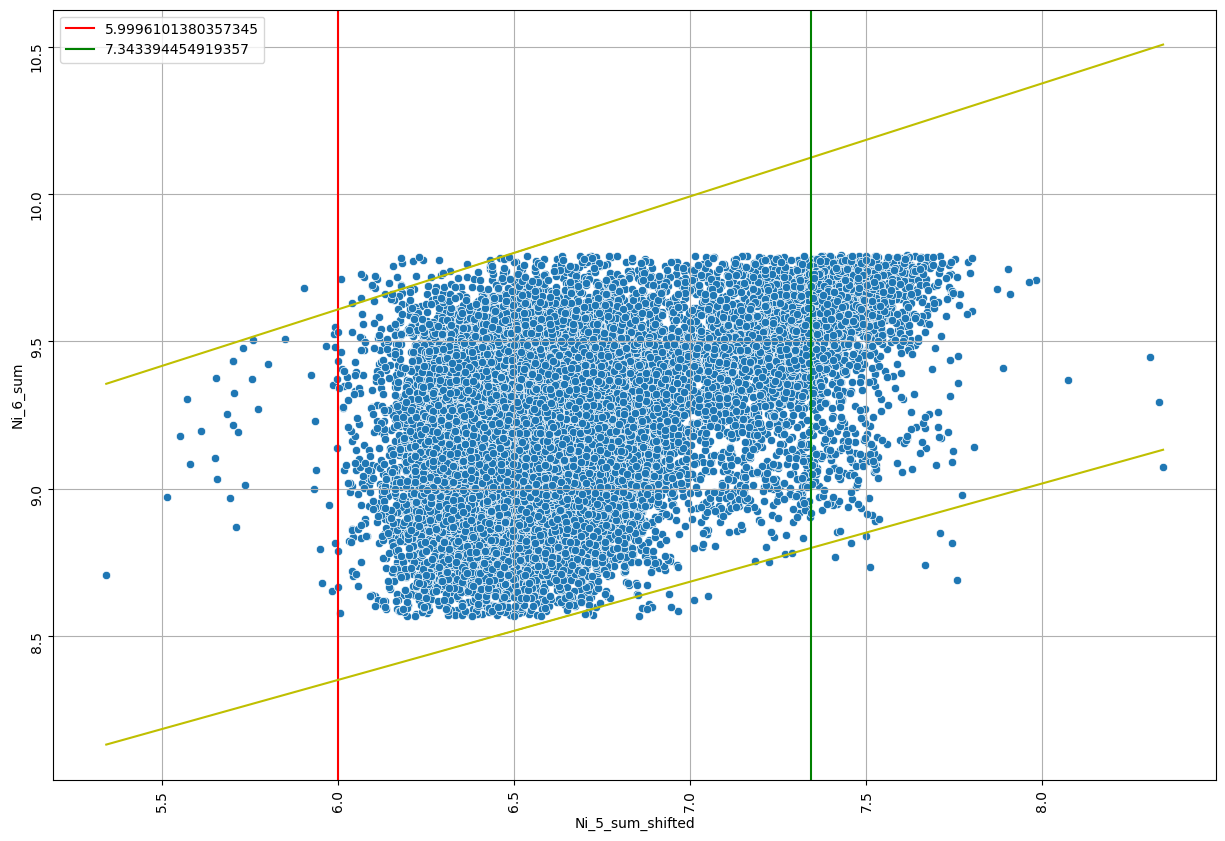

In [63]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_6, x='Ni_5_sum_shifted', y='Ni_6_sum').tick_params(labelrotation = 90)
plt.axvline(x=data_for_step_6['Ni_5_sum_shifted'].mean() - 1.96 * data_for_step_6['Ni_5_sum_shifted'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_6['Ni_5_sum_shifted'].mean() - 1.96 * data_for_step_6['Ni_5_sum_shifted'].std())
sns.lineplot(data_for_step_6, x='Ni_5_sum_shifted', y='Ni5_predict_lower', color='y')
sns.lineplot(data_for_step_6, x='Ni_5_sum_shifted', y='Ni5_predict_upper', color='y')
plt.axvline(x=data_for_step_6['Ni_5_sum_shifted'].mean() + 1.96 * data_for_step_6['Ni_5_sum_shifted'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_6['Ni_5_sum_shifted'].mean() + 1.96 * data_for_step_6['Ni_5_sum_shifted'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [64]:
df_working['Ni_4_sum'] = (df_working['Ni_4.1C'] + df_working['Ni_4.2C']) / 2
df_working['Ni_4_sum_shifted'] = df_working['Ni_4_sum'].shift(4)

In [65]:
lower_bound_5 = data_for_step_6['Ni_5_sum_shifted'].mean() - 1.96 * data_for_step_6['Ni_5_sum_shifted'].std()
upper_bound_5 = data_for_step_6['Ni_5_sum_shifted'].mean() + 1.96 * data_for_step_6['Ni_5_sum_shifted'].std()

data_for_step_5 = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04') & (df_working['Ni_5_sum'] > lower_bound_5) & (df_working['Ni_5_sum'] < upper_bound_5)]

In [66]:
model_4 = LinearRegression()

model_4.fit(X=data_for_step_5[['Ni_4_sum_shifted']].fillna(data_for_step_5[['Ni_4_sum_shifted']].mean()), y=data_for_step_5['Ni_5_sum'].fillna(data_for_step_5['Ni_5_sum'].mean()))

y_hat_4 = model_4.predict(data_for_step_5[['Ni_4_sum_shifted']].fillna(data_for_step_5[['Ni_4_sum_shifted']].mean()))
data_for_step_5['Ni4_predict'] = y_hat_4
data_for_step_5['Ni4_predict_upper'] = y_hat_4 + y_hat_4*0.08
data_for_step_5['Ni4_predict_lower'] = y_hat_4 - y_hat_4*0.08

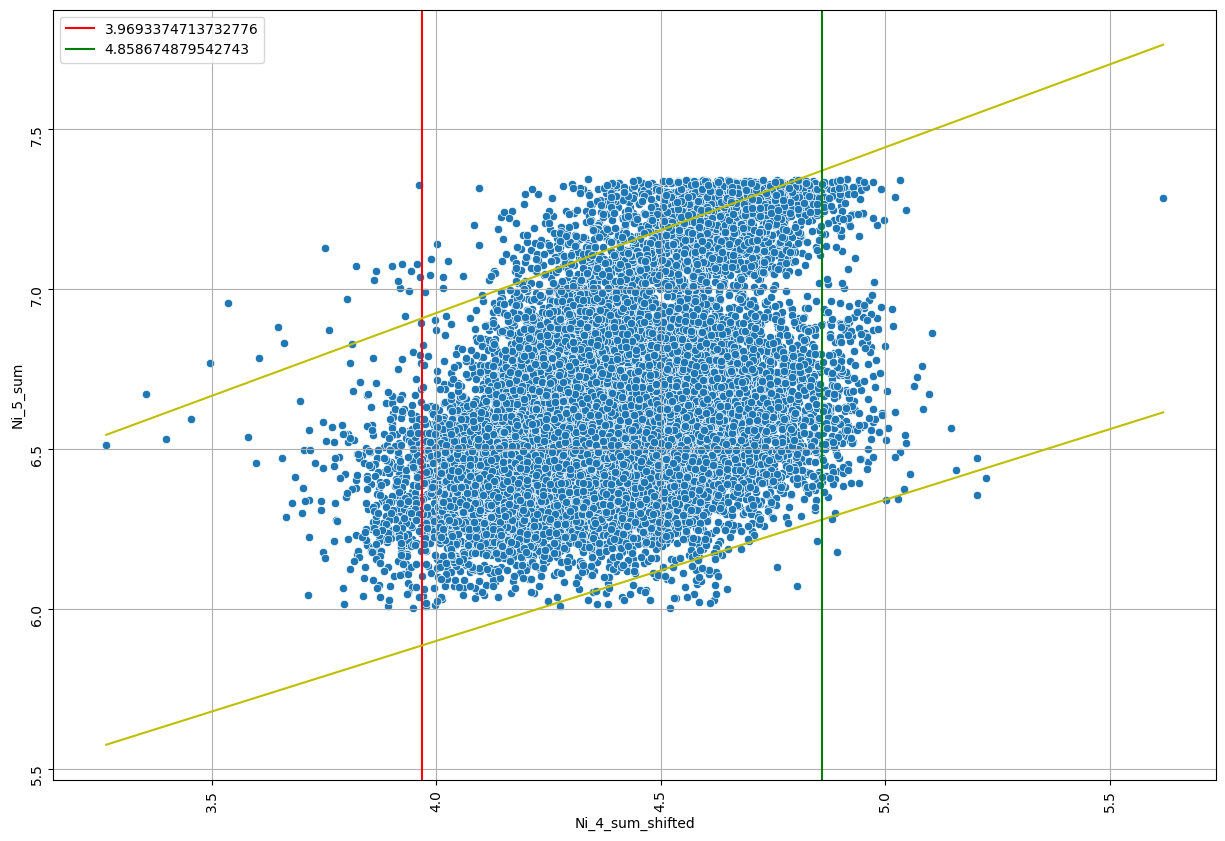

In [67]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_5, x='Ni_4_sum_shifted', y='Ni_5_sum').tick_params(labelrotation = 90)
plt.axvline(x=data_for_step_5['Ni_4_sum_shifted'].mean() - 1.96 * data_for_step_5['Ni_4_sum_shifted'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_5['Ni_4_sum_shifted'].mean() - 1.96 * data_for_step_5['Ni_4_sum_shifted'].std())
sns.lineplot(data_for_step_5, x='Ni_4_sum_shifted', y='Ni4_predict_lower', color='y')
sns.lineplot(data_for_step_5, x='Ni_4_sum_shifted', y='Ni4_predict_upper', color='y')
plt.axvline(x=data_for_step_5['Ni_4_sum_shifted'].mean() + 1.96 * data_for_step_5['Ni_4_sum_shifted'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_5['Ni_4_sum_shifted'].mean() + 1.96 * data_for_step_5['Ni_4_sum_shifted'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [68]:
df_working['Ni_3_sum'] = (df_working['Ni_3.1T'] + df_working['Ni_3.2T']) / 2
df_working['Ni_3_sum_shifted'] = df_working['Ni_3_sum'].shift(5)

df_working['Ni_2_sum'] = (df_working['Ni_2.1T'] + df_working['Ni_2.2T']) / 2
df_working['Ni_2_sum_shifted'] = df_working['Ni_2_sum'].shift(6)

df_working['Ni_6_tail_sum'] = (df_working['Ni_6.1T'] + df_working['Ni_6.2T']) / 2
df_working['Ni_6_tail_sum_shifted'] = df_working['Ni_6_tail_sum'].shift(2)

df_working['Ni_2_3_6_tail_sum'] = df_working['Ni_3_sum_shifted'] + df_working['Ni_2_sum_shifted'] + df_working['Ni_6_tail_sum_shifted']

In [69]:
lower_bound_4 = data_for_step_5['Ni_4_sum_shifted'].mean() - 1.96 * data_for_step_5['Ni_4_sum_shifted'].std()
upper_bound_4 = data_for_step_5['Ni_4_sum_shifted'].mean() + 1.96 * data_for_step_5['Ni_4_sum_shifted'].std()

data_for_step_4 = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04') & (df_working['Ni_4_sum'] > lower_bound_4) & (df_working['Ni_4_sum'] < upper_bound_4)]

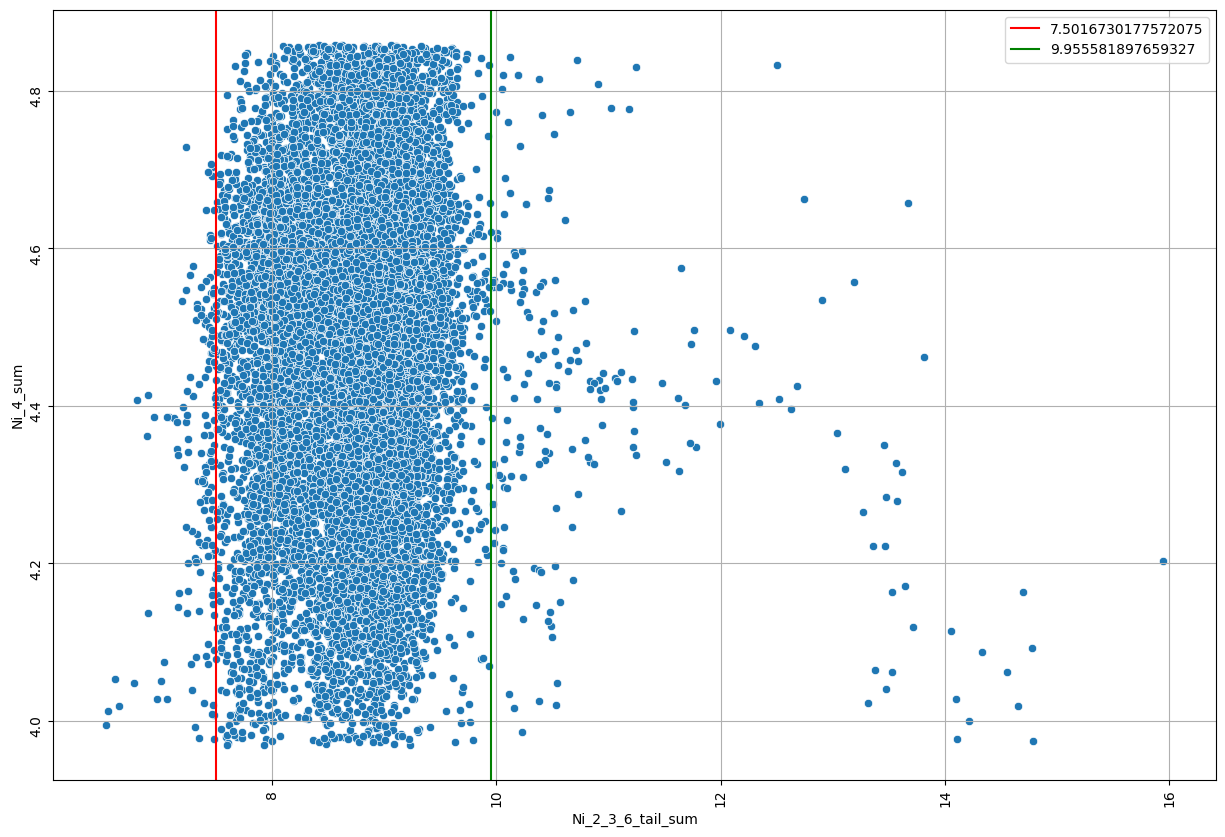

In [70]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_4, x='Ni_2_3_6_tail_sum', y='Ni_4_sum').tick_params(labelrotation = 90)
plt.axvline(x=data_for_step_4['Ni_2_3_6_tail_sum'].mean() - 1.96 * data_for_step_4['Ni_2_3_6_tail_sum'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_4['Ni_2_3_6_tail_sum'].mean() - 1.96 * data_for_step_4['Ni_2_3_6_tail_sum'].std())
plt.axvline(x=data_for_step_4['Ni_2_3_6_tail_sum'].mean() + 1.96 * data_for_step_4['Ni_2_3_6_tail_sum'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_4['Ni_2_3_6_tail_sum'].mean() + 1.96 * data_for_step_4['Ni_2_3_6_tail_sum'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [71]:
lower_bound_3 = data_for_step_4['Ni_2_3_6_tail_sum'].mean() - 1.96 * data_for_step_4['Ni_2_3_6_tail_sum'].std()
upper_bound_3 = data_for_step_4['Ni_2_3_6_tail_sum'].mean() + 1.96 * data_for_step_4['Ni_2_3_6_tail_sum'].std()

In [72]:
df_working['Ni_2_sum'] = (df_working['Ni_2.1C'] + df_working['Ni_2.2C']) / 2
df_working['Ni_2_sum_shifted'] = df_working['Ni_2_sum'].shift(6)

In [73]:
lower_bound_tail_result_2 = data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_2_sum_shifted'].mean() - 1.96 * data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_2_sum_shifted'].std()
upper_bound_tail_result_2 = data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_2_sum_shifted'].mean() + 1.96 * data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_2_sum_shifted'].std()

lower_bound_tail_result_3 = data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_3_sum_shifted'].mean() - 1.96 * data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_3_sum_shifted'].std()
upper_bound_tail_result_3 = data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_3_sum_shifted'].mean() + 1.96 * data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_3_sum_shifted'].std()

lower_bound_tail_result_6 = data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_6_tail_sum_shifted'].mean() - 1.96 * data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_6_tail_sum_shifted'].std()
upper_bound_tail_result_6 = data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_6_tail_sum_shifted'].mean() + 1.96 * data_for_step_4[(data_for_step_4['Ni_2_3_6_tail_sum'] > lower_bound_3) & data_for_step_4['Ni_2_3_6_tail_sum'] < upper_bound_3]['Ni_6_tail_sum_shifted'].std()

In [74]:
data_for_step_3 = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04')  & (df_working['Ni_3_sum'] > lower_bound_tail_result_3) & (df_working['Ni_3_sum'] < upper_bound_tail_result_3)]

In [75]:
model_3 = LinearRegression()

model_3.fit(X=data_for_step_3[['Ni_2_sum_shifted']].fillna(data_for_step_3[['Ni_2_sum_shifted']].mean()), y=data_for_step_3['Ni_3_sum'].fillna(data_for_step_3['Ni_3_sum'].mean()))

y_hat_3 = model_3.predict(data_for_step_3[['Ni_2_sum_shifted']].fillna(data_for_step_3[['Ni_2_sum_shifted']].mean()))
data_for_step_3['Ni2_predict'] = y_hat_3
data_for_step_3['Ni2_predict_upper'] = y_hat_3 + y_hat_3*0.12
data_for_step_3['Ni2_predict_lower'] = y_hat_3 - y_hat_3*0.12

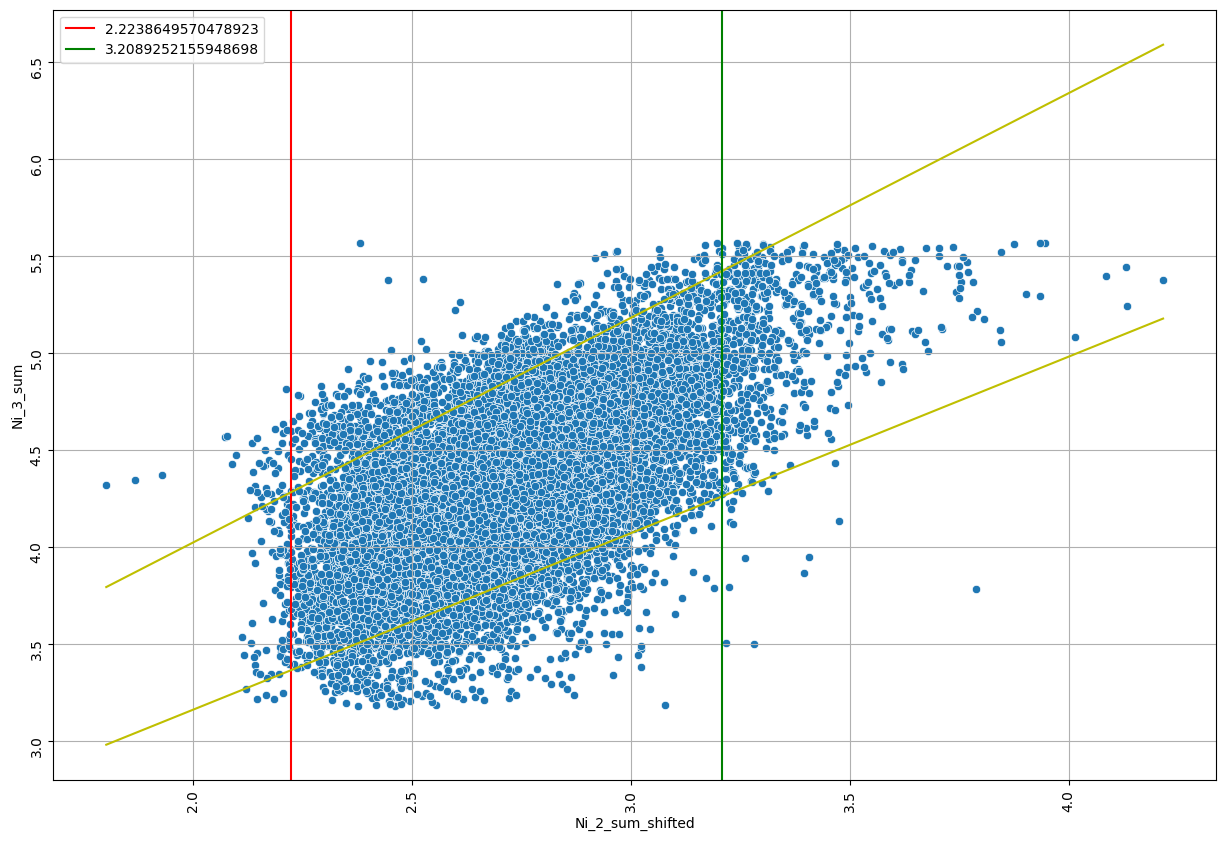

In [76]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_3, x='Ni_2_sum_shifted', y='Ni_3_sum').tick_params(labelrotation = 90)
plt.axvline(x=data_for_step_3['Ni_2_sum_shifted'].mean() - 1.96 * data_for_step_3['Ni_2_sum_shifted'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_3['Ni_2_sum_shifted'].mean() - 1.96 * data_for_step_3['Ni_2_sum_shifted'].std())
sns.lineplot(data_for_step_3, x='Ni_2_sum_shifted', y='Ni2_predict_lower', color='y')
sns.lineplot(data_for_step_3, x='Ni_2_sum_shifted', y='Ni2_predict_upper', color='y')
plt.axvline(x=data_for_step_3['Ni_2_sum_shifted'].mean() + 1.96 * data_for_step_3['Ni_2_sum_shifted'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_3['Ni_2_sum_shifted'].mean() + 1.96 * data_for_step_3['Ni_2_sum_shifted'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [77]:
df_working['Ni_1_sum'] = (df_working['Ni_1.1C'] + df_working['Ni_1.2C']) / 2
df_working['Ni_1_sum_shifted'] = df_working['Ni_1_sum'].shift(7)

In [78]:
lower_bound_2 = data_for_step_3['Ni_2_sum_shifted'].mean() - 1.96 * data_for_step_3['Ni_2_sum_shifted'].std()
upper_bound_2 = data_for_step_3['Ni_2_sum_shifted'].mean() + 1.96 * data_for_step_3['Ni_2_sum_shifted'].std()

data_for_step_2 = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04')  & (df_working['Ni_2_sum'] > lower_bound_2) & (df_working['Ni_2_sum'] < upper_bound_2)]

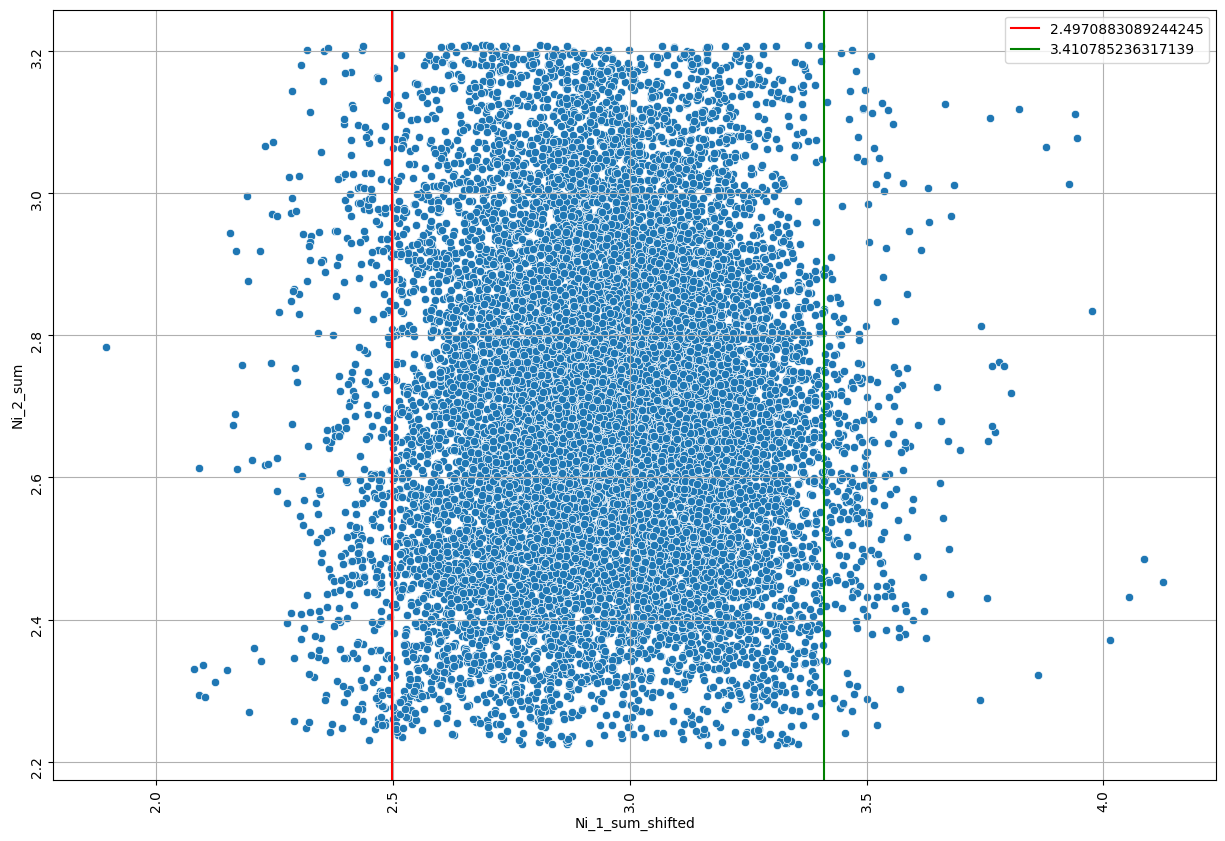

In [79]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_2, x='Ni_1_sum_shifted', y='Ni_2_sum').tick_params(labelrotation = 90)
plt.axvline(x=data_for_step_2['Ni_1_sum_shifted'].mean() - 1.96 * data_for_step_2['Ni_1_sum_shifted'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_2['Ni_1_sum_shifted'].mean() - 1.96 * data_for_step_2['Ni_1_sum_shifted'].std())
plt.axvline(x=data_for_step_2['Ni_1_sum_shifted'].mean() + 1.96 * data_for_step_2['Ni_1_sum_shifted'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_2['Ni_1_sum_shifted'].mean() + 1.96 * data_for_step_2['Ni_1_sum_shifted'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [80]:
lower_bound_1 = data_for_step_2['Ni_1_sum_shifted'].mean() - 1.96 * data_for_step_2['Ni_1_sum_shifted'].std()
upper_bound_1 = data_for_step_2['Ni_1_sum_shifted'].mean() + 1.96 * data_for_step_2['Ni_1_sum_shifted'].std()

data_for_step_1 = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].astype(str) < '2024-09-30 21') & (df_working['MEAS_DT'].astype(str) > '2024-01-01 04')  & (df_working['Ni_2_sum'] > lower_bound_1) & (df_working['Ni_2_sum'] < upper_bound_1)]

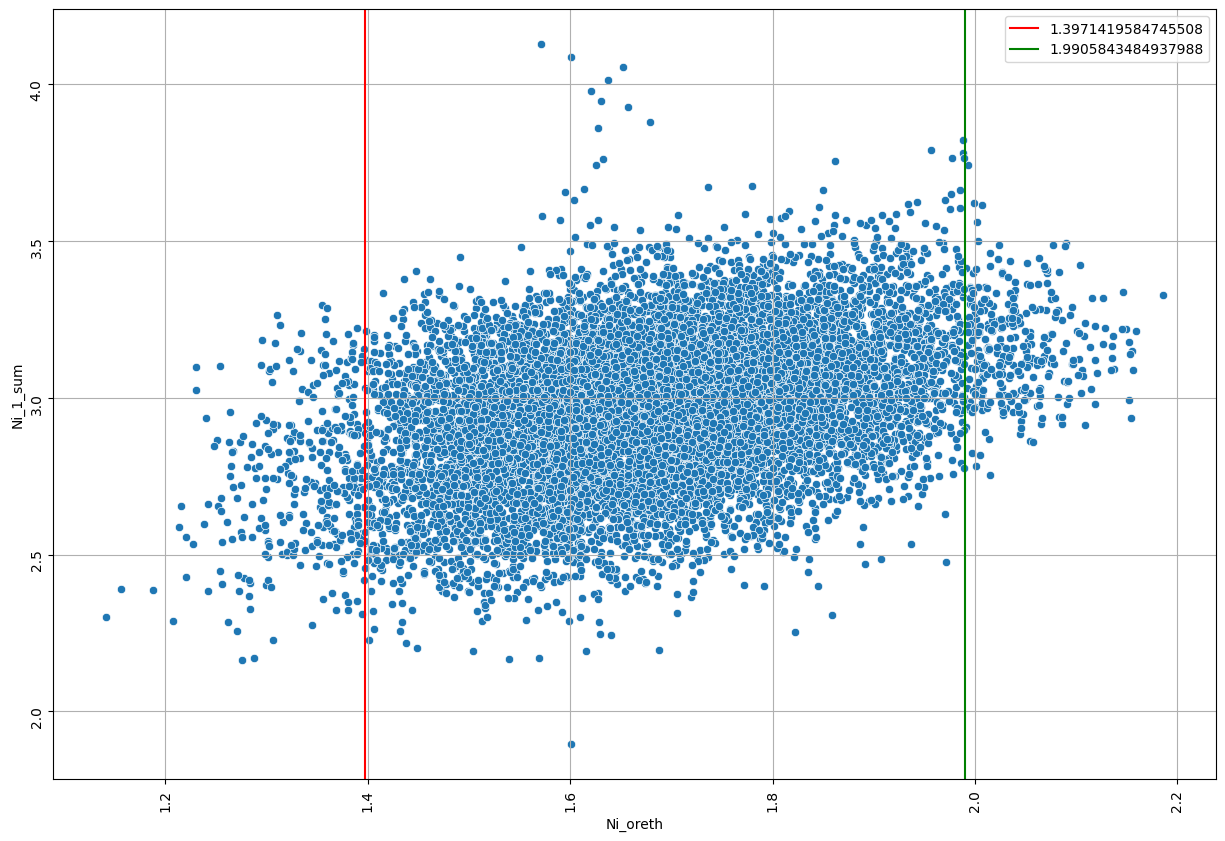

In [81]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_1, x='Ni_oreth', y='Ni_1_sum').tick_params(labelrotation = 90)
plt.axvline(x=data_for_step_1['Ni_oreth'].mean() - 1.96 * data_for_step_1['Ni_oreth'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_1['Ni_oreth'].mean() - 1.96 * data_for_step_1['Ni_oreth'].std())
plt.axvline(x=data_for_step_1['Ni_oreth'].mean() + 1.96 * data_for_step_1['Ni_oreth'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_1['Ni_oreth'].mean() + 1.96 * data_for_step_1['Ni_oreth'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [82]:
model_1 = LinearRegression()

model_1.fit(X=data_for_step_1[['Ni_oreth']].fillna(data_for_step_1[['Ni_oreth']].mean()), y=data_for_step_1['Ni_1_sum'].fillna(data_for_step_1['Ni_1_sum'].mean()))

LinearRegression()

In [83]:
y_hat = model_1.predict(data_for_step_1[['Ni_oreth']].fillna(data_for_step_1[['Ni_oreth']].mean()))
data_for_step_1['Ni1_predict'] = y_hat
data_for_step_1['Ni1_predict_upper'] = y_hat + y_hat*0.09
data_for_step_1['Ni1_predict_lower'] = y_hat - y_hat*0.09

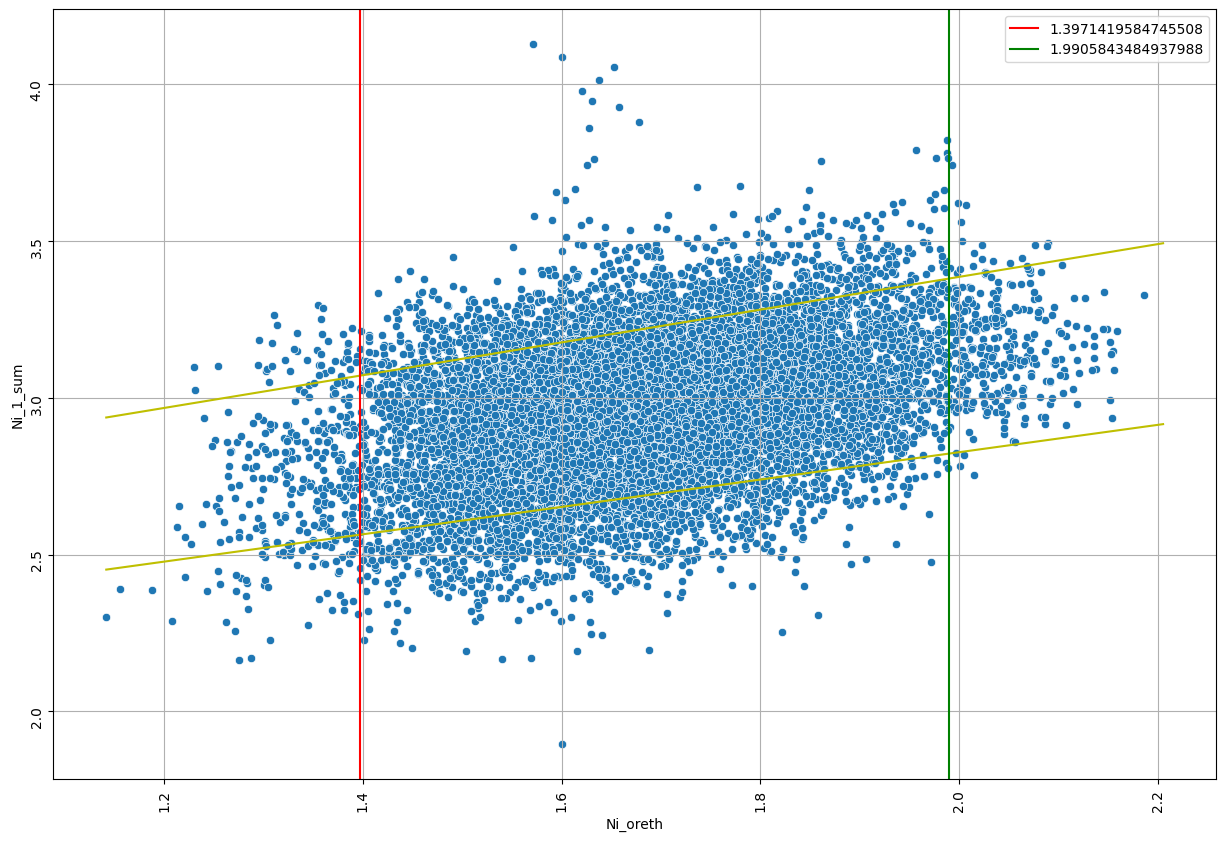

In [84]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_1, x='Ni_oreth', y='Ni_1_sum').tick_params(labelrotation = 90)
#sns.lineplot(data_for_step_1, x='Ni_oreth', y='Ni1_predict', color='y')
sns.lineplot(data_for_step_1, x='Ni_oreth', y='Ni1_predict_lower', color='y')
sns.lineplot(data_for_step_1, x='Ni_oreth', y='Ni1_predict_upper', color='y')
plt.axvline(x=data_for_step_1['Ni_oreth'].mean() - 1.96 * data_for_step_1['Ni_oreth'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_1['Ni_oreth'].mean() - 1.96 * data_for_step_1['Ni_oreth'].std())
plt.axvline(x=data_for_step_1['Ni_oreth'].mean() + 1.96 * data_for_step_1['Ni_oreth'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_1['Ni_oreth'].mean() + 1.96 * data_for_step_1['Ni_oreth'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [85]:
lower_bound_0 = data_for_step_1['Ni_oreth'].mean() - 1.96 * data_for_step_1['Ni_oreth'].std()
upper_bound_0 = data_for_step_1['Ni_oreth'].mean() + 1.96 * data_for_step_1['Ni_oreth'].std()

In [86]:
data_for_step_1['Ni_oreth'] = data_for_step_1['Ni_oreth'].fillna(data_for_step_1['Ni_oreth'].mean())
data_for_step_1['Ni_1_sum'] = data_for_step_1['Ni_1_sum'].fillna(data_for_step_1['Ni_1_sum'].mean())
data_for_step_1['Ore_mass'] = data_for_step_1['Ore_mass'].fillna(data_for_step_1['Ore_mass'].mean())

model_multi = LinearRegression()

model_multi.fit(X=data_for_step_1[['Ore_mass', 'Ni_oreth']], y=data_for_step_1['Ni_1_sum'])

y_hat_final = model_multi.predict(data_for_step_1[['Ore_mass', 'Ni_oreth']])
data_for_step_1['Ni1_predict'] = y_hat_final
data_for_step_1['Ni1_predict_upper'] = y_hat_final + y_hat_final*0.07
data_for_step_1['Ni1_predict_lower'] = y_hat_final - y_hat_final*0.07

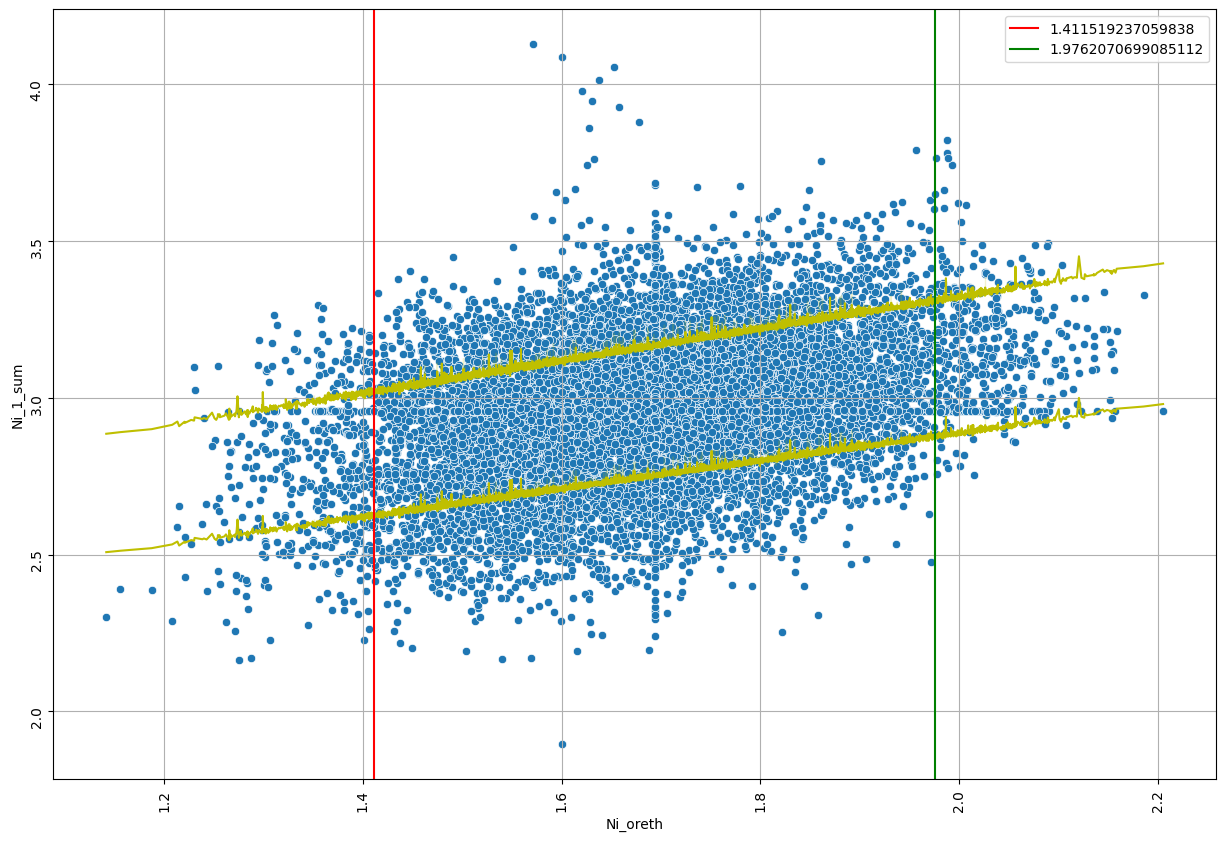

In [87]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_1, x='Ni_oreth', y='Ni_1_sum').tick_params(labelrotation = 90)
#sns.lineplot(data_for_step_1, x='Ni_oreth', y='Ni1_predict', color='y')
sns.lineplot(data_for_step_1, x='Ni_oreth', y='Ni1_predict_lower', color='y')
sns.lineplot(data_for_step_1, x='Ni_oreth', y='Ni1_predict_upper', color='y')
plt.axvline(x=data_for_step_1['Ni_oreth'].mean() - 1.96 * data_for_step_1['Ni_oreth'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_1['Ni_oreth'].mean() - 1.96 * data_for_step_1['Ni_oreth'].std())
plt.axvline(x=data_for_step_1['Ni_oreth'].mean() + 1.96 * data_for_step_1['Ni_oreth'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_1['Ni_oreth'].mean() + 1.96 * data_for_step_1['Ni_oreth'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

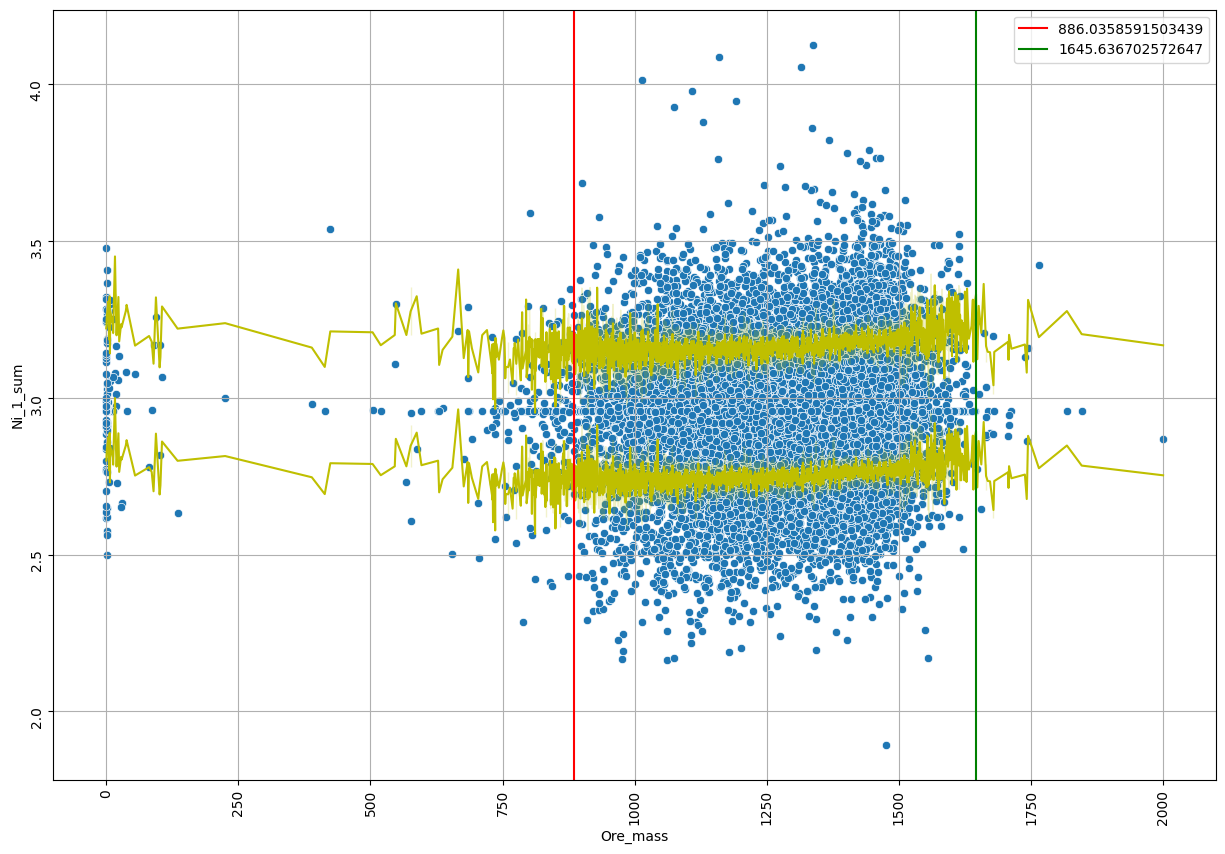

In [88]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(data_for_step_1, x='Ore_mass', y='Ni_1_sum').tick_params(labelrotation = 90)
#sns.lineplot(data_for_step_1, x='Ni_oreth', y='Ni1_predict', color='y')
sns.lineplot(data_for_step_1, x='Ore_mass', y='Ni1_predict_lower', color='y')
sns.lineplot(data_for_step_1, x='Ore_mass', y='Ni1_predict_upper', color='y')
plt.axvline(x=data_for_step_1['Ore_mass'].mean() - 1.96 * data_for_step_1['Ore_mass'].std(),
            color='r',
            linestyle='-',
            label=data_for_step_1['Ore_mass'].mean() - 1.96 * data_for_step_1['Ore_mass'].std())
plt.axvline(x=data_for_step_1['Ore_mass'].mean() + 1.96 * data_for_step_1['Ore_mass'].std(),
            color='g',
            linestyle='-',
            label=data_for_step_1['Ore_mass'].mean() + 1.96 * data_for_step_1['Ore_mass'].std())
plt.grid(visible=True)
plt.legend()
fig.show()

In [190]:
test_data = pd.read_csv('test.csv')
test_data['MEAS_DT'] = pd.to_datetime(test_data['MEAS_DT'])

In [234]:
df_test = df_working[(df_working['Ni_rec'] < 1.00) & (df_working['MEAS_DT'].isin(test_data['MEAS_DT']))].dropna()

test_sample = df_test

def predict(data, diap_percent):

  def myround(x, prec=2, base=.05):
    return round(base * round(float(x) / base), prec)

  vf = np.vectorize(myround)

  fm1 = model_1.predict(data[['Ni_oreth']])

  fm1_1C_max = fm1 + fm1 * diap_percent
  fm1_1C_min = fm1 - fm1 * diap_percent

  fm1_1C_max = fm1_1C_max.round(1)
  fm1_1C_min = fm1_1C_min.round(1)

  fm1_2C_max = fm1 + fm1 * diap_percent
  fm1_2C_min = fm1 - fm1 * diap_percent

  fm1_2C_max = fm1_2C_max.round(1)
  fm1_2C_min = fm1_2C_min.round(1)

  fm4_1C_min = vf(np.repeat(np.array(lower_bound_4), len(data)))
  fm4_1C_max = vf(np.repeat(np.array(upper_bound_4), len(data)))

  fm4_2C_min = vf(np.repeat(np.array(lower_bound_4), len(data)))
  fm4_2C_max = vf(np.repeat(np.array(upper_bound_4), len(data)))

  data['Ni_4_sum'] = (data['Ni_4.1C'] + data['Ni_4.2C']) / 2
  data['Ni_4_sum_shifted'] = data['Ni_4_sum'].shift(4)

  fm5 = model_4.predict(data[['Ni_4_sum_shifted']].fillna(data[['Ni_4_sum_shifted']].mean()))

  fm5_1C_max = fm5 + fm5 * diap_percent
  fm5_1C_min = fm5 - fm5 * diap_percent

  fm5_1C_max = vf(fm5_1C_max)
  fm5_1C_min = vf(fm5_1C_min)

  fm5_2C_max = fm5 + fm5 * diap_percent
  fm5_2C_min = fm5 - fm5 * diap_percent

  fm5_2C_max = vf(fm5_2C_max)
  fm5_2C_min = vf(fm5_2C_min)

  data['Ni_5_sum'] = (data['Ni_5.1C'] + data['Ni_5.2C']) / 2
  data['Ni_5_sum_shifted'] = data['Ni_5_sum'].shift(3)

  fm6 = model_5.predict(data[['Ni_5_sum_shifted']].fillna(data[['Ni_5_sum_shifted']].mean()))

  fm6_1C_max = fm6 + fm6 * diap_percent
  fm6_1C_min = fm6 - fm6 * diap_percent

  fm6_1C_max = vf(fm6_1C_max)
  fm6_1C_min = vf(fm6_1C_min)

  fm6_2C_max = fm6 + fm6 * diap_percent
  fm6_2C_min = fm6 - fm6 * diap_percent

  fm6_2C_max = vf(fm6_2C_max)
  fm6_2C_min = vf(fm6_2C_min)

  df_result = pd.DataFrame({'date': data['MEAS_DT'],
                     'fm1_1C_min': fm1_1C_min,
                     'fm1_1C_max': fm1_1C_max,
                     'fm1_2C_max': fm1_2C_max,
                     'fm1_2C_min': fm1_2C_min,
                     'fm4_1C_min': fm4_1C_min,
                     'fm4_1C_max': fm4_1C_max,
                     'fm4_2C_min': fm4_2C_min,
                     'fm4_2C_max': fm4_2C_max,
                     'fm5_1C_max': fm5_1C_max,
                     'fm5_1C_min': fm5_1C_min,
                     'fm5_2C_max': fm5_2C_max,
                     'fm5_2C_min': fm5_2C_min,
                     'fm6_1C_max': fm6_1C_max,
                     'fm6_1C_min': fm6_1C_min,
                     'fm6_2C_max': fm6_2C_max,
                     'fm6_2C_min': fm6_2C_min
                     })

  return df_result

In [235]:
predict(test_sample, 0.1)[:500]

MEAS_DT      last_change_dt  can_change
1777 2024-01-19 12:15:00 2024-11-05 16:15:00       False
1778 2024-01-19 12:30:00 2024-11-05 16:15:00       False
1779 2024-01-19 12:45:00 2024-11-05 16:15:00       False
1780 2024-01-19 13:00:00 2024-11-05 16:15:00       False
1781 2024-01-19 13:15:00 2024-11-05 16:15:00       False
...                  ...                 ...         ...
9930 2024-04-13 10:30:00 2024-11-05 16:15:00       False
9931 2024-04-13 10:45:00 2024-11-05 16:15:00       False
9934 2024-04-13 11:30:00 2024-11-05 16:15:00       False
9935 2024-04-13 11:45:00 2024-11-05 16:15:00       False
9936 2024-04-13 12:00:00 2024-11-05 16:15:00       False

[500 rows x 3 columns]

In [236]:
import pickle
filename = 'model_1.sav'
pickle.dump(model_1, open(filename, 'wb'))

filename_2 = 'model_4.sav'
pickle.dump(model_4, open(filename_2, 'wb'))

filename_3 = 'model_5.sav'
pickle.dump(model_5, open(filename_3, 'wb'))

In [237]:
upper_bound_4

4.858674879542743

In [238]:
lower_bound_4

3.9693374713732776